# Analyze escape scores estimated for each strain relative to each serum sample

## Import `Python` modules

In [1]:
import os
import sys
import glob
import pandas as pd
from collections import defaultdict
import lzma

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

## Assign each serum sample to a cohort

In [2]:
cohort_dict = {
    'children' : [
        3944,
        2389,
        2323,
        2388,
        3973,
        4299,
        4584,
        2367,
    ],
    'teenagers' : [
        2350,
        2365,
        2382,
        3866,
        2380,
        3856, # outlier
        3857,
        3862,
    ],
    'adults' : [
        '33C',
        '34C',
        '197C',
        '199C',
        '215C',
        '210C',
        '74C',
        '68C',
        '150C',
        '18C',
    ],
    'elderly' : [
        'AUSAB-13'
    ],
    'infant' : [
        2462
    ]
}
serum_to_cohort_dict = defaultdict(list)
for (cohort, sera) in cohort_dict.items():
    for serum in sera:
        serum_to_cohort_dict['cohort'].append(cohort)
        serum_to_cohort_dict['serum'].append(str(serum))
serum_to_cohort_df = pd.DataFrame(serum_to_cohort_dict)

## Analyze predicted escape scores

For each serum sample, read in predicted escape scores for each virus on the Nextstrain tree. Also read in metadata for each virus (e.g., sampling date). Finally, for each serum sample, output one file per serum sample with columns giving strain, escape score, and date, without mutation info so that these files can be included in the publication.

In [5]:
# Read in escape scores
yr = 12
resultsdir = f'builds/flu_seasonal_h3n2_{yr}y/ha/dmsa-phenotype/all-sera/'
fs = glob.glob(os.path.join(resultsdir, '*.csv'))
dfs = []
for f in fs:
    serum = os.path.basename(f).replace('_avg.csv_variant_escape_prediction.csv', '')
    df = pd.read_csv(f)
    df['serum'] = serum
    df.rename(columns={'pred_phenotype':'escape_score'}, inplace=True)
    dfs.append(df)
escape_df = pd.concat(dfs)

# Drop escape scores for internal nodes
escape_df = escape_df[~escape_df['strain'].str.contains('NODE')]

In [12]:
# Read in escape scores
yr = 12
resultsdir = f'builds/flu_seasonal_h3n2_{yr}y/ha/dmsa-phenotype/all-sera/'
fs = glob.glob(os.path.join(resultsdir, '*.csv'))
dfs = []
for f in fs:
    serum = os.path.basename(f).replace('_avg.csv_variant_escape_prediction.csv', '')
    df = pd.read_csv(f)
    df['serum'] = serum
    df.rename(columns={'pred_phenotype':'escape_score'}, inplace=True)
    dfs.append(df)
escape_df = pd.concat(dfs)

# Drop escape scores for internal nodes
escape_df = escape_df[~escape_df['strain'].str.contains('NODE')]

# Add metadata
metadata_df = pd.read_csv(f'profiles/dmsa-phenotype/sequences/{yr}y_metadata.tsv.xz', sep=',')
metadata_df['date'] = pd.to_datetime(metadata_df['date'], errors='coerce')
escape_df = escape_df.merge(metadata_df, on='strain')
escape_df = escape_df.merge(serum_to_cohort_df, on='serum', how='left')

# Add a column giving time in years since a reference date of the start of 2020
escape_df['time'] = (escape_df['date'] - pd.to_datetime('2020-01-01')).dt.days / 365
escape_df['year'] = 2020 + escape_df['time']

# Remove entries for strains with times corresponding to NaN, which occurs if the
# date entry had ambiguity (e.g., year but not month or day)
escape_df = escape_df[escape_df['time'].notnull()]

# Create an output file with just strain, escape_score, and date
output_f = os.path.join(resultsdir, 'all_escape_scores_for_paper', 'all_escape_scores.csv')
escape_df[['strain', 'serum', 'escape_score', 'date']].to_csv(output_f, index=False)

How many strains have mutations that are "disallowed", either because they were not measured in the DMS experiment, or they were not present in at least two libraries and in at least three variants per library (averaged across libraries)?

In [4]:
print('Number of strains:', len(escape_df['strain'].unique()))
print('Number of strain masked for >=1 serum sample', sum(escape_df.groupby('strain')['n_disallowed_aa_substitutions'].sum() > 0))
print('Number of strains masked for 0 serum samples', sum(escape_df.groupby('strain')['n_disallowed_aa_substitutions'].sum() == 0))


Number of strains: 1473
Number of strain masked for >=1 serum sample 240
Number of strains masked for 0 serum samples 1233


Here is a list of disallowed mutations that are appearing most frequently, with the count column indicating the number of strains that have a given mutation.

In [5]:
# Get a list of all disallowed subs
disallowed_subs = []
data = escape_df[escape_df['n_disallowed_aa_substitutions'] > 0]
for subs in data['disallowed_aa_substitutions']:
    disallowed_subs += subs.split(' ')

# Make a dataframe with counts
counts_dict = defaultdict(list)
(subs, counts) = np.unique(disallowed_subs, return_counts = True)
for (sub, count) in zip(subs, counts):
    counts_dict['sub'].append(sub)
    counts_dict['count'].append(count)
counts_df = pd.DataFrame(counts_dict)
counts_df['site'] = counts_df['sub'].apply(lambda x: int(x[1:-1]))
counts_df[['site', 'sub', 'count']].sort_values('count', ascending=False).head(n=10)

,site,sub,count
8,104,D104G,1989
21,79,F79V,1209
62,194,L194P,585
98,205,S205F,507
72,168,M168V,429
61,157,L157I,273
31,140,I140R,273
85,221,P221L,234
9,104,D104N,156
116,130,V130I,152


Plot the escape score of each strain as a function of strain collection date, with escape scores averaged across all serum samples in a given cohort.

Number of unique strains analyzed: 1239


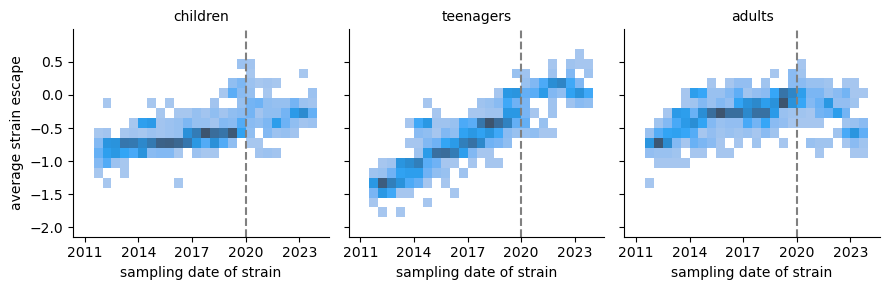

In [6]:
# Get data
cohorts = [
    #'infant',
    'children', 'teenagers', 'adults',
    # 'elderly'
]
data = escape_df[
    (escape_df['n_disallowed_aa_substitutions'] == 0) &
    (escape_df['cohort'].isin(cohorts))
].groupby(['strain', 'cohort'])[['escape_score', 'year']].mean().reset_index()
print('Number of unique strains analyzed:', len(data['strain'].unique()))

# Plot data
binsx = np.arange(-9, 4.5, 0.5)
binsx += 2020
binsy = np.arange(-2, 1, 0.15)
g = sns.FacetGrid(data, col="cohort", col_order=cohorts)
g.map(
    sns.histplot, "year", "escape_score",
    bins=(binsx, binsy)
)
for ax in g.axes[0]:
   ax.axvline(2020, ls='--', c='0.5')
g.set(
    ylabel='average strain escape', xlabel='sampling date of strain',
    xticks=[2011, 2014, 2017, 2020, 2023]
)
g.set_titles("{col_name}")
plt.show()

## Use randomization testing to test whether changes in antigenic escape over time differ between cohorts

To do this, we will first fit a linear-regression model that uses a strain's collection date (in years relative to the beginning of 2020) to predict the strain's average escape score from a given cohort, as plotted above. We will fit one model per cohort. Next, we will randomize which serum sample is associated with which cohort, and then repeat the above analysis, fitting one model to the randomized data from each cohort. We will perform 1,000 independent randomizations and then will compare the slopes inferred from the randomized data to the ones inferred for the non-randomized data.

First, perform 1,000 independent randomizations of cohort assignments using a random seed for reproducibility.

In [7]:
# Get data for cohorts of interest, only considering viruses with no disallowed substitutions
# and inferred dates
cohorts = ['children', 'teenagers', 'adults']
rand_df = escape_df[
    (escape_df['n_disallowed_aa_substitutions'] == 0) &
    (escape_df['cohort'].isin(cohorts))
].copy()

# Randomize cohort assignments, creating a new column for each independent randomization.
# Use a random seed to make this process reproducible
rng = np.random.default_rng(seed=2)
n_randomizations = 1000
cohort_cols = ['cohort']
for n in range(1, n_randomizations+1):
    #rand_df[f'rand_cohort_{n}'] = list(rand_df['cohort'].sample(frac=1, random_state=rng))
    rand_serum_to_cohort_df = serum_to_cohort_df[serum_to_cohort_df['cohort'].isin(cohorts)].copy()
    rand_col_name = f'rand_cohort_{n}'
    rand_serum_to_cohort_df[rand_col_name] = list(rand_serum_to_cohort_df['cohort'].sample(frac=1, random_state=rng))
    rand_df = rand_df.merge(rand_serum_to_cohort_df[['serum', rand_col_name]], on='serum', how='left')
    cohort_cols.append(f'rand_cohort_{n}')

Next, for each set of cohort assignments (including real and randomized ones), fit a linear regression to the data from each cohort and record the slope and y-intercept from each model.

In [8]:
slope_dict = defaultdict(list)
for cohort_col in cohort_cols:
    data = rand_df.groupby([cohort_col, 'strain'])[['escape_score', 'year']].mean().reset_index()
    for cohort in data[cohort_col].unique():
        data_reg = data[
            #(data['time'] >= 0) &
            (data[cohort_col] == cohort)
        ]
        reg = LinearRegression().fit(data_reg[['year']], data_reg['escape_score'])
        slope = reg.coef_[0]
        intercept = reg.intercept_
        slope_dict['cohort_col'].append(cohort_col)
        slope_dict['cohort'].append(cohort)
        slope_dict['slope'].append(slope)
        slope_dict['intercept'].append(intercept)

slope_df = pd.DataFrame(slope_dict)
slope_df['randomization'] = slope_df['cohort_col'] != 'cohort'
slope_df.head(n=6)

,cohort_col,cohort,slope,intercept,randomization
0,cohort,adults,0.036891,-74.714578,False
1,cohort,children,0.056363,-114.271601,False
2,cohort,teenagers,0.139245,-281.497999,False
3,rand_cohort_1,adults,0.047317,-95.884154,True
4,rand_cohort_1,children,0.095589,-193.297880,True
5,rand_cohort_1,teenagers,0.088658,-179.386534,True


Plot the best-fit lines for the non-randomized data (or a given randomized dataset by changing `cohort_col`).

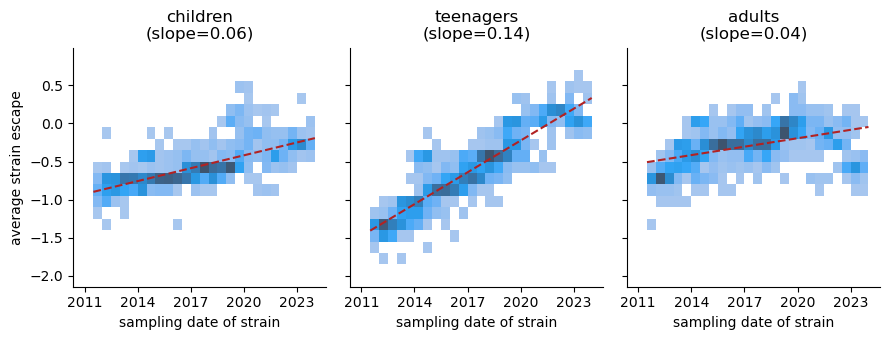

In [9]:
# Function for plotting the regression line
def abline(slope, intercept, axs):
    """Plot a line from slope and intercept"""
    x_vals = np.array((2020-8.5, 2020+4.0)) # np.array(axs.get_xlim())
    y_vals = intercept + slope * x_vals
    axs.plot(x_vals, y_vals, '--', c='firebrick')

# Specify which set of cohort assigments to use
cohort_col = 'cohort' # 'rand_cohort_12' # 

# Get data to make the 2D histograms
data = rand_df.groupby(['strain', cohort_col])[['escape_score', 'year']].mean().reset_index()

# Plot data
(fig, axs) = plt.subplots(ncols=3, figsize=[9,3.5], sharex=True, sharey=True)
for (i, cohort) in enumerate(cohorts):

    # Plot the 2D histogram
    data_i = data[data[cohort_col] == cohort]
    sns.histplot(x='year', y='escape_score', data=data_i, ax=axs[i], bins=(binsx, binsy))

    # Plot the regression line
    (slope, intercept) = slope_df[
        (slope_df['cohort_col'] == cohort_col) &
        (slope_df['cohort'] == cohort)
    ][['slope', 'intercept']].iloc[0]
    abline(slope, intercept, axs[i])
    axs[i].set(
        xlabel='sampling date of strain',
        xticks=[2011, 2014, 2017, 2020, 2023],
        title=f'{cohort}\n(slope={round(slope, 2)})'
    )

axs[0].set(ylabel='average strain escape')
plt.tight_layout()
sns.despine()
plt.show()

Next, for each set of cohort assignments (randomized and non-randomized), compute the difference in the slope fit to a given cohort compared to the adult cohort (change `ref_cohort` to compare slopes to a different reference). This difference metric will allow us to test the hypothesis that the metric is larger in the non-randomized data than the randomized data.

In [10]:
delta_slope_df = slope_df.pivot_table(index='cohort_col', columns='cohort', values='slope')
ref_cohort = 'adults' # 'children' # 
for cohort in cohorts:
    delta_slope_df[f'delta_{cohort}'] = delta_slope_df[cohort] - delta_slope_df[ref_cohort]
delta_slope_df['randomization'] = delta_slope_df.index.str.contains('rand_')
delta_slope_df.head()

cohort,adults,children,teenagers,delta_children,delta_teenagers,delta_adults,randomization
cohort_col,,,,,,,
cohort,0.036891,0.056363,0.139245,0.019472,0.102354,0.0,False
rand_cohort_1,0.047317,0.095589,0.088658,0.048272,0.041341,0.0,True
rand_cohort_10,0.023175,0.135109,0.078735,0.111933,0.055559,0.0,True
rand_cohort_100,0.074671,0.068195,0.081310,-0.006476,0.006639,0.0,True
rand_cohort_1000,0.071927,0.100482,0.052750,0.028555,-0.019177,0.0,True


For the actual data from each cohort, get the difference in the slope for given cohort vs. the slope for adults. This value is positive for both children and teenagers. Next, do the same thing for each of the randomized data, and determine how many times the differences in slope are more positive than what was observed in the actual data. We will use this number to compute a p-value.

Analyzing data from cohort: children
Difference in slope (children-adults): 0.019
Number of randomizations analyzed: 1000
Number of randomizations where the observed difference is more positive than the actual difference: 323
Distribution of differences from randomized data, with red line showing actual difference:


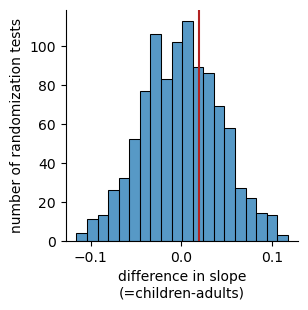

Analyzing data from cohort: teenagers
Difference in slope (teenagers-adults): 0.102
Number of randomizations analyzed: 1000
Number of randomizations where the observed difference is more positive than the actual difference: 4
Distribution of differences from randomized data, with red line showing actual difference:


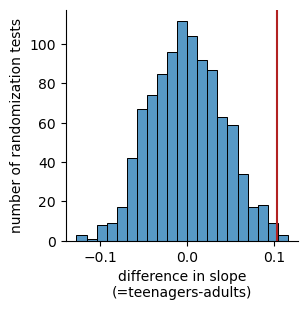

In [11]:
# Get dataframes containing the original actual data vs. randomized data
original_data = delta_slope_df[delta_slope_df['randomization'] == False]
rand_data = delta_slope_df[delta_slope_df['randomization'] == True]

# Loop over cohorts and analyze differences in slopes between cohorts
# for the actual data vs randomized data
for cohort in cohorts:
    if cohort == ref_cohort:
        continue
    print(f'Analyzing data from cohort: {cohort}')
    original_delta = original_data[f'delta_{cohort}'].iloc[0]
    print(f'Difference in slope ({cohort}-{ref_cohort}):', round(original_delta, 3))
    print('Number of randomizations analyzed:', len(rand_data))
    print('Number of randomizations where the observed difference is more positive than the actual difference:', sum(rand_data[f'delta_{cohort}'] >= original_delta))
    print('Distribution of differences from randomized data, with red line showing actual difference:')
    plt.figure(figsize=[3,3])
    #plt.title(cohort)
    sns.histplot(rand_data[f'delta_{cohort}'])
    plt.axvline(original_delta, c='firebrick')
    plt.xlabel(f'difference in slope\n(={cohort}-{ref_cohort})')
    plt.ylabel('number of randomization tests')
    sns.despine()
    plt.show()

## Plot data for all serum samples in a given cohort

infant


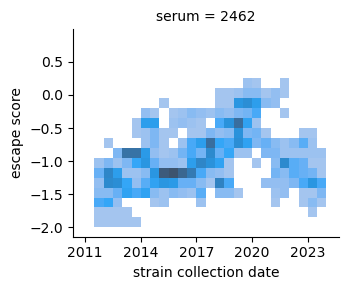

children


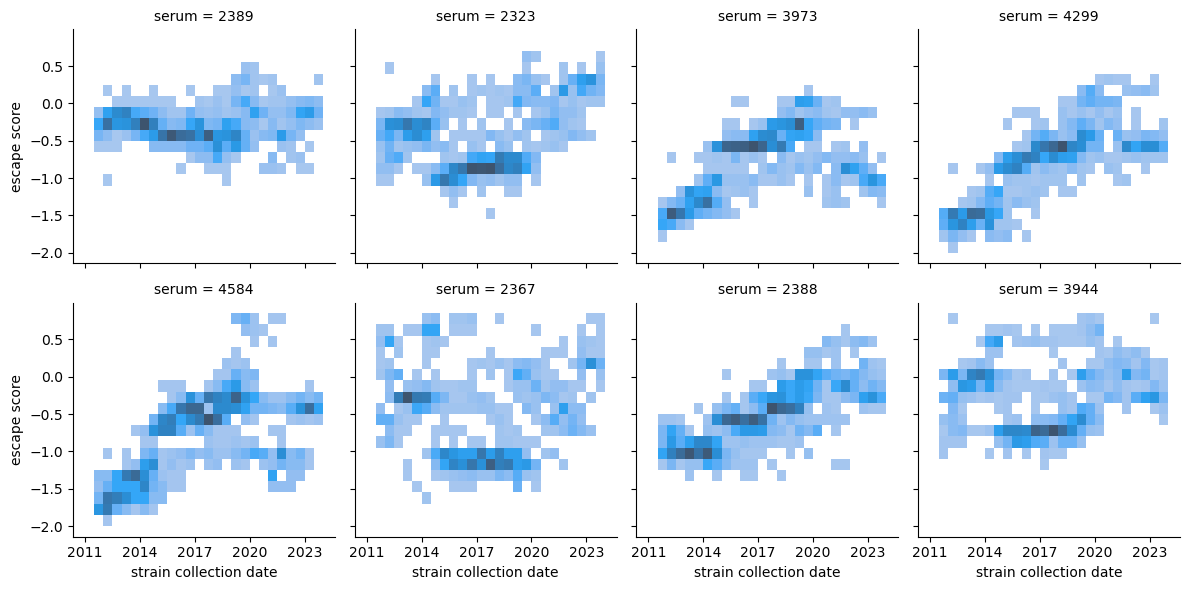

teenagers


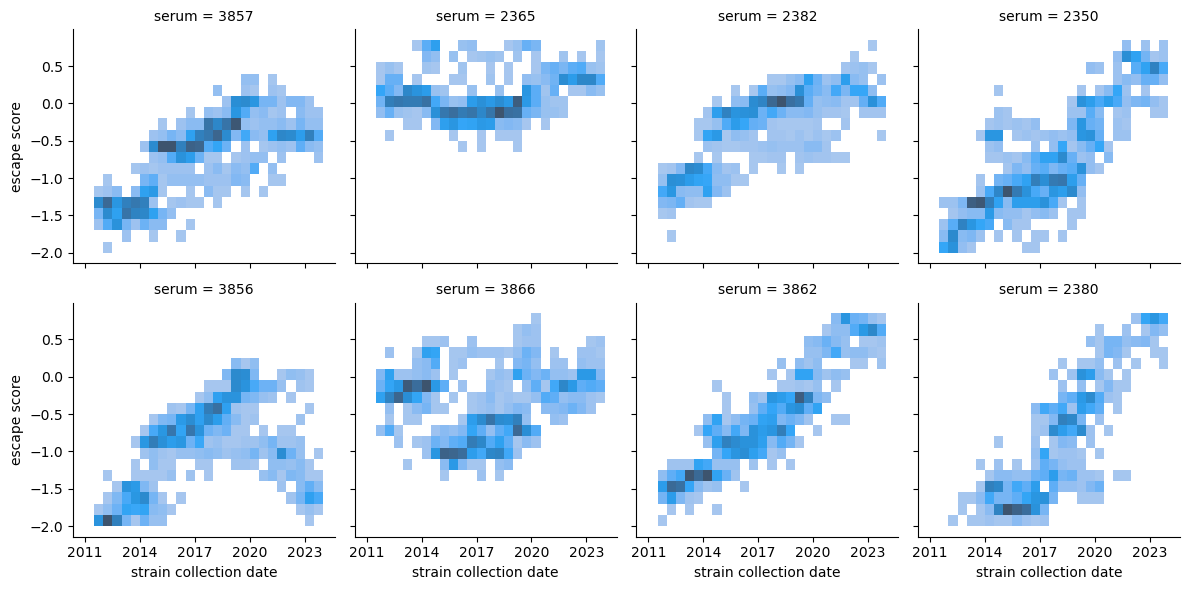

adults


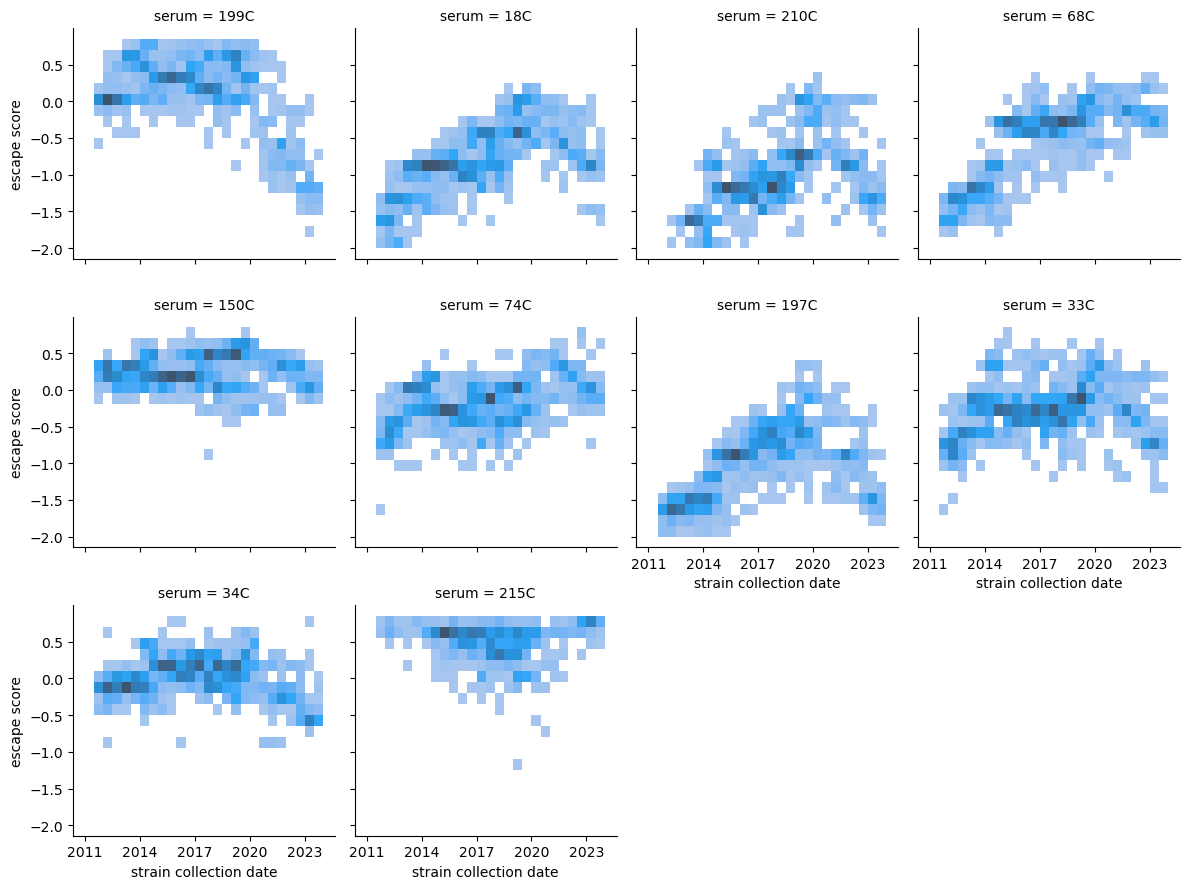

In [12]:
cohorts = ['infant', 'children', 'teenagers', 'adults']
for cohort in cohorts:
    print(cohort)
    data = escape_df[
        (escape_df['n_disallowed_aa_substitutions'] == 0) &
        (escape_df['cohort'] == cohort)
    ]
    #binsx = np.arange(-9, 4.5, 0.5)
    #binsy = np.arange(-3, 2, 0.15)
    g = sns.FacetGrid(data, col="serum", col_wrap=4)
    g.map(
        sns.histplot, "year", "escape_score",
        bins=(binsx, binsy)
    )
    g.set(
        ylabel='escape score', xlabel='strain collection date',
        xticks=[2011, 2014, 2017, 2020, 2023],
    )
    plt.show()